# Titanic's data analysis and machine learning
## By Jérémy P. Schneider

As someone new in this field, I decided to take my first challenge with the Titanic dataset from Kaggle (https://www.kaggle.com/c/titanic)

## My OS
For this work I used a computer with :
    * Windows 7
    * Intel(R) Core(TM) i5-2500K CPU @ 3.30GHz
    * 16 Go RAM (4 x 4 Go)
    * NVIDIA GeForce GTX 1050 Ti

This notebook will be split in different part :

## [Setting our environnement :](#ENV)

### [Libraries Import](#lib)
### [Personnalized functions and tools](#func)
### [Data import](#import)

## [Data cleaning and analysis :](#CLEAN)
### [Data analysis](#analysis)
### [Handeling missing data](#MISSING)
### [Converting all data in number](#convert)


## [Test and train a model](#test_train)

## [Conclusion and trial over the test sample](#conclusion)

<a id="ENV"></a>
# Setting our environnement
<a id="lib"></a>
## Libraries Import

In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import numpy as np
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix

<a id="func"></a>
## Personalized functions and tools

Since the Titanic dataset contains a name with a title, I used the idea of Ertuğrul Demir to create a dictionary to replace them (https://www.kaggle.com/datafan07/titanic-eda-and-several-modelling-approaches)

In [2]:
dict_title = {
    'Capt': 'Dr/Clerc/Mil',
    'Col': 'Dr/Clerc/Mil',
    'Major': 'Dr/Clerc/Mil',
    'Jonkheer': 'Honor',
    'Don': 'Honor',
    'Dona': 'Honor',
    'Sir': 'Honor',
    'Dr': 'Dr/Clerc/Mil',
    'Rev': 'Dr/Clerc/Mil',
    'the Countess': 'Honor',
    'Mme': 'Mrs',
    'Mlle': 'Miss',
    'Ms': 'Mrs',
    'Mr': 'Mr',
    'Mrs': 'Mrs',
    'Miss': 'Miss',
    'Master': 'Master',
    'Lady': 'Honor'
}

def extractTitle(df, nameCol, dictTitle):
    '''
    extractTitle(df, nameCol, dictTitle)
    Input : df : dataframe, will be copied.
            nameCol : name of the columns where to extract titles.
            dictTitle : dictionary of title and their conversion.
    This fonction extract title from a specific column with a custom dict and remove nameCol.
    '''
    
    df_new = df.copy()
    df_new["Title"] = ""
    for row in range(df_new.shape[0]):
        name = df_new.loc[row][nameCol]
        for title in dictTitle:
            if title in name:
                df_new["Title"][row] = dictTitle[title]
    return df_new.drop([nameCol], axis=1)

def getDummiesTitanic(df, dummies):
    '''
    getDummiesTitanic(df, dummies)
    Input : df : dataframe, will be copied.
            dummies : list of dummies to transform.
            dictTitle : dictionary of title and their conversion
    This fonction get dummies for a given list and drop the original column.
    '''
    df_new = df.copy()
    for dummy in dummies:
        try :
            df_new = df_new.join(pd.get_dummies(df_new[dummy], prefix = dummy))
            df_new = df_new.drop([dummy], axis=1)
        except KeyError:
            print("Warning : column {} is missing".format(dummy))
        
    return df_new

def drawConfusionMatrix(y_test, y_pred):
    '''
    drawConfusionMatrix(y_test, y_pred)
    Input : y_test : list of real target.
            y_pred : list of predicted target.

    This fonction draw a confusion matrix from y_test and y_pred.
    '''
    cf_matrix = confusion_matrix(y_test, y_pred)
    cm_sum = np.sum(cf_matrix, axis=1, keepdims=True)
    cm_perc = cf_matrix / cm_sum.astype(float) * 100
    annot = np.empty_like(cf_matrix).astype(str)
    nrows, ncols = cf_matrix.shape
    labels = ["Died", "Survived"]
    sns.heatmap(cf_matrix/np.sum(cf_matrix), 
                xticklabels=labels, 
                yticklabels=labels, 
                annot=True)
    plt.yticks(rotation=0)
    plt.ylabel('Predicted values', rotation=0)
    plt.xlabel('Actual values')
    plt.show()

<a id="import"></a>
## Data import

In [3]:
df_train_org = pd.read_csv("data/train.csv")
df_test_org = pd.read_csv("data/test.csv")

<a id="CLEAN"></a>
# Data cleaning and analysis

<a id="analysis"></a>
## Data analysis

From Kaggle we know how the data is ordered and it define our goal :

The data has been split into two groups:

    training set (train.csv)
    test set (test.csv)

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

### Data Dictionary

|Variable	    |Definition	        |Key
| ------------- |:-----------------:| -----:|
|survival 	    |Survival 	        |0 = No, 1 = Yes
|pclass 	    |Ticket class 	    |1 = 1st, 2 = 2nd, 3 = 3rd
|sex 	        |Sex 	
|Age 	        |Age in years 	
|sibsp 	        |# of siblings / spouses aboard the Titanic 	
|parch 	        |# of parents / children aboard the Titanic 	
|ticket         |Ticket number 	
|fare 	        |Passenger fare 	
|cabin 	        |Cabin number 	
|embarked 	    |Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton

### Variable Notes

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

If we watch how the data is in our ile, wa saw that the information is correct.

* First the train data



In [4]:
df_train_org.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [5]:
print("In the train data we have {} rows and {} columns".format(df_train_org.shape[0], df_train_org.shape[1]))

In the train data we have 891 rows and 12 columns


* Then the test data

In [6]:
df_test_org.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [7]:
print("In the test data we have {} rows and {} columns".format(df_test_org.shape[0], df_test_org.shape[1]))

In the test data we have 418 rows and 11 columns


As we see the two set have the same topology :
* int and float for numerical values.
* object for text data.

We'll need to transform the text data in numerical values in order to feed our machine learning model.

### Checking correlation

We first remplace __Sex__ and __Embarked__ with numerical values based on the occurencies on the train data. 

Since we don't want to have biais we won't look too deep in the test data.

In [8]:
df_train_org["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [9]:
df_train_org["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [10]:
df_train = df_train_org.copy()
df_train = df_train.drop(["PassengerId", "Ticket"],axis=1) # Remove unique ID
df_train["SexNum"] = df_train["Sex"]
df_train["SexNum"].loc[df_train["SexNum"] == "male"] = 1
df_train["SexNum"].loc[df_train["SexNum"] == "female"] = 0

df_train["EmbarkedNum"] = df_train["Embarked"]
df_train["EmbarkedNum"] = df_train["EmbarkedNum"].fillna(0)
df_train["EmbarkedNum"].loc[df_train["EmbarkedNum"] == "S"] = 2
df_train["EmbarkedNum"].loc[df_train["EmbarkedNum"] == "C"] = 1
df_train["EmbarkedNum"].loc[df_train["EmbarkedNum"] == "Q"] = 0
df_train["EmbarkedNum"] = df_train["EmbarkedNum"].astype(int)

df_test= df_test_org.copy()
df_test= df_test.drop(["PassengerId", "Ticket"],axis=1) # Remove unique ID
df_test["SexNum"] = df_test["Sex"]
df_test["SexNum"].loc[df_test["SexNum"] == "male"] = 1
df_test["SexNum"].loc[df_test["SexNum"] == "female"] = 0

df_test["EmbarkedNum"] = df_test["Embarked"]
df_test["EmbarkedNum"] = df_test["EmbarkedNum"].fillna(0)
df_test["EmbarkedNum"].loc[df_test["EmbarkedNum"] == "S"] = 2
df_test["EmbarkedNum"].loc[df_test["EmbarkedNum"] == "C"] = 1
df_test["EmbarkedNum"].loc[df_test["EmbarkedNum"] == "Q"] = 0
df_test["EmbarkedNum"] = df_test["EmbarkedNum"].astype(int)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Then we compute the correlation

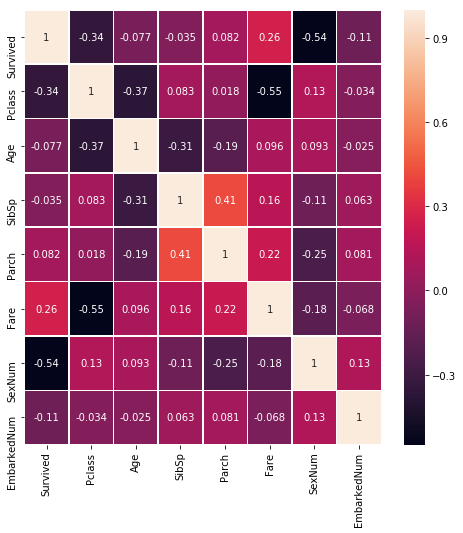

This graphic took me : 00:00:00


In [11]:
start_time = time.time()
plt.figure(figsize=(8,8))
sns.heatmap(df_train.corr(), annot=True, linewidths=.5, annot_kws={"size":10})
plt.show()
elapsed_time = time.time() - start_time
print("This graphic took me : {}".format(time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))

We can se that we have :
* a weak negative correclation between __PClass__ and __Survived__ : 1st class survived more.
* a weak positive correlation between __Survived__ and __Fare__ : if you have more money you wuold have survived.
* a weak negative correlation between __Survived__ and __SexNum__ : more women survived.
* a weak negative correlation between __Pclass__ and __Fare__ : 1st class have more money than 3rd.
* a weak positive correlation between __SibSp__ and __Parch__ : since it's the number of family onboard it's logical.

<a id="MISSING"></a>
### Handeling missing data

After checking the type of the data we use, we need to see where missing values are, to do so we can simply calculated them this way :

In [12]:
df_train.isna().mean()

Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
SexNum         0.000000
EmbarkedNum    0.000000
dtype: float64

In [13]:
df_test.isna().mean()

Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.205742
SibSp          0.000000
Parch          0.000000
Fare           0.002392
Cabin          0.782297
Embarked       0.000000
SexNum         0.000000
EmbarkedNum    0.000000
dtype: float64

From this step we know :
* __Cabin__ information is missing in more than 75% of our data, so we'll not use it.
* __Age__ information is missing at 20% of the time, we'll try to remplace the missing values
* __Embarked__ information is missing several values in the trainset
* __Fare__ information is missing serveral values in the testset

We can use three method to take care of the missing data points
* Remove columns

In [14]:
df_train_remove = df_train.drop(["Cabin", "Age", "Embarked", "Fare"], axis=1)
df_test_remove = df_test.drop(["Cabin", "Age", "Embarked", "Fare"], axis=1)

* Compute MEAN for numerical, and most occurent for categorical

For Embarked we take at look at the data

In [15]:
df_train["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [16]:
start_time = time.time()
df_train_mean = df_train.drop(["Cabin"], axis=1).copy()
df_train_mean["Age"] = df_train_mean["Age"].fillna(df_train_mean["Age"].mean())
df_train_mean["Embarked"] = df_train_mean["Embarked"].fillna("S")
df_test_mean = df_test.drop(["Cabin"], axis=1).copy()
df_test_mean["Age"] = df_test_mean["Age"].fillna(df_test_mean["Age"].mean())
df_test_mean["Fare"] = df_test_mean["Fare"].fillna(df_test_mean["Fare"].mean())
elapsed_time = time.time() - start_time
print("This calculations took me : {}".format(time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))

This calculations took me : 00:00:00


In [17]:
df_train_mean.isna().sum()

Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
SexNum         0
EmbarkedNum    0
dtype: int64

* Compute MEDIAN for numerical and most occurent for categorical

In [18]:
df_train_median = df_train.drop(["Cabin"], axis=1).copy()
df_train_median["Age"] = df_train_median["Age"].fillna(df_train_median["Age"].median())
df_train_median["Embarked"] = df_train_median["Embarked"].fillna("S")
df_test_median = df_test.drop(["Cabin"], axis=1).copy()
df_test_median["Age"] = df_test_median["Age"].fillna(df_test_median["Age"].median())
df_test_median["Fare"] = df_test_median["Fare"].fillna(df_test_median["Fare"].median())

<a id="convert"></a>
### Converting all data in number

We'll first take care of the name column. We'll extract the title from the names. (REF)

The steps are :
* Create a new column
* Read each names
* Check if any title exist in the name
* Add the title in the new column

We'll need to do it on all our datasets, so we can use the fonction defined before.

In [19]:
start_time = time.time()
df_train_remove = extractTitle(df_train_remove, "Name", dict_title)
df_test_remove = extractTitle(df_test_remove, "Name", dict_title)
df_train_mean = extractTitle(df_train_mean, "Name", dict_title)
df_test_mean = extractTitle(df_test_mean, "Name", dict_title)
df_train_median = extractTitle(df_train_median, "Name", dict_title)
df_test_median = extractTitle(df_test_median, "Name", dict_title)
elapsed_time = time.time() - start_time
print("This calculations took me : {}".format(time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


This calculations took me : 00:02:45


One of the most current way to deal with categorical data is to [get dummies](https://towardsdatascience.com/the-dummys-guide-to-creating-dummy-variables-f21faddb1d40)

In [20]:
df_train_remove.head()

,Survived,Pclass,Sex,SibSp,Parch,SexNum,EmbarkedNum,Title
0,0,3,male,1,0,1,2,Mr
1,1,1,female,1,0,0,1,Mrs
2,1,3,female,0,0,0,2,Miss
3,1,1,female,1,0,0,2,Mrs
4,0,3,male,0,0,1,2,Mr


In [21]:
start_time = time.time()
list_dummies = ["Sex", "Embarked", "Title"]

df_train_remove = getDummiesTitanic(df_train_remove, list_dummies)
df_test_remove = getDummiesTitanic(df_test_remove, list_dummies)
df_train_mean = getDummiesTitanic(df_train_mean, list_dummies)
df_test_mean = getDummiesTitanic(df_test_mean, list_dummies)
df_train_median = getDummiesTitanic(df_train_median, list_dummies)
df_test_median = getDummiesTitanic(df_test_median, list_dummies)
elapsed_time = time.time() - start_time
print("This calculations took me : {}".format(time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))

This calculations took me : 00:00:00


In [22]:
df_train_remove.head()

,Survived,Pclass,SibSp,Parch,SexNum,EmbarkedNum,Sex_female,Sex_male,Title_Dr/Clerc/Mil,Title_Honor,Title_Master,Title_Miss,Title_Mr,Title_Mrs
0,0,3,1,0,1,2,0,1,0,0,0,0,1,0
1,1,1,1,0,0,1,1,0,0,0,0,0,0,1
2,1,3,0,0,0,2,1,0,0,0,0,1,0,0
3,1,1,1,0,0,2,1,0,0,0,0,0,0,1
4,0,3,0,0,1,2,0,1,0,0,0,0,1,0


## MinMaxScaler

In [23]:
df_train_remove_minmax = df_train_remove.copy()
df_test_remove_minmax = df_test_remove.copy()
df_train_mean_minmax = df_train_mean.copy()
df_test_mean_minmax = df_test_mean.copy()
df_train_median_minmax = df_train_median.copy()
df_test_median_minmax = df_test_median.copy()

### Searching features to standardize

In [24]:
list_remove = []
list_mean = []
list_median = []

scaler = MinMaxScaler()

for column in df_train_remove_minmax.columns:
    if df_train_remove_minmax[column].max() > 1:
        list_remove.append(column)
    
df_train_remove_minmax[list_remove] = scaler.fit_transform(df_train_remove_minmax[list_remove])
df_test_remove_minmax[list_remove] = scaler.fit_transform(df_test_remove_minmax[list_remove])

for column in df_train_mean_minmax.columns:
    if df_train_mean_minmax[column].max() > 1:
        list_mean.append(column)
    
df_train_mean_minmax[list_mean] = scaler.fit_transform(df_train_mean_minmax[list_mean])
df_test_mean_minmax[list_mean] = scaler.fit_transform(df_test_mean_minmax[list_mean])

for column in df_train_median_minmax.columns:
    if df_train_median_minmax[column].max() > 1:
        list_median.append(column)
    
df_train_median_minmax[list_median] = scaler.fit_transform(df_train_median_minmax[list_median])
df_test_median_minmax[list_median] = scaler.fit_transform(df_test_median_minmax[list_median])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype

<a id="test_train"></a>
## Test and train a model

First we need to split the datasets in train and test. The mesure the preformance of our models.

We also create a dict to record all the scores.

In [25]:
X_train_remove, X_test_remove, y_train_remove, y_test_remove = train_test_split(df_train_remove.drop(["Survived"], axis=1), 
                                                               df_train_remove["Survived"], 
                                                               test_size=0.2,
                                                               random_state=0)

X_train_mean, X_test_mean, y_train_mean, y_test_mean = train_test_split(df_train_mean.drop(["Survived"], axis=1), 
                                                       df_train_mean["Survived"], 
                                                       test_size=0.2,
                                                       random_state=0)
X_train_median, X_test_median, y_train_median, y_test_median = train_test_split(df_train_median.drop(["Survived"], axis=1), 
                                                               df_train_median["Survived"], 
                                                               test_size=0.2,
                                                               random_state=0)

X_train_remove_minmax, X_test_remove_minmax, y_train_remove_minmax, y_test_remove_minmax = train_test_split(df_train_remove_minmax.drop(["Survived"], axis=1), 
                                                               df_train_remove_minmax["Survived"], 
                                                               test_size=0.2,
                                                               random_state=0)

X_train_mean_minmax, X_test_mean_minmax, y_train_mean_minmax, y_test_mean_minmax = train_test_split(df_train_mean_minmax.drop(["Survived"], axis=1), 
                                                       df_train_mean_minmax["Survived"], 
                                                       test_size=0.2,
                                                       random_state=0)
X_train_median_minmax, X_test_median_minmax, y_train_median_minmax, y_test_median_minmax = train_test_split(df_train_median_minmax.drop(["Survived"], axis=1), 
                                                               df_train_median_minmax["Survived"], 
                                                               test_size=0.2,
                                                               random_state=0)


SCORES = {"Remove":{},"Mean":{},"Median":{},"Remove_minmax":{},"Mean_minmax":{},"Median_minmax":{}}

### With the SVM (Support Vector Machines [see documentation](https://scikit-learn.org/stable/modules/svm.html)) :

* If we use the df_train_remove :

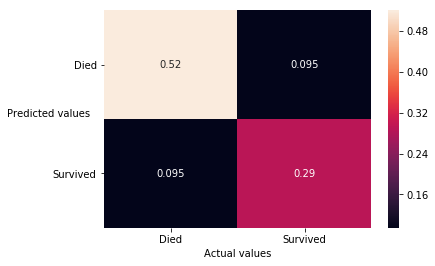

Perfomace is : 81.01% for SVM_Remove
This calculations took me : 00:00:00


In [26]:
start_time = time.time()
clf = svm.SVC(kernel='linear', C = 1.0) #Check other models
clf.fit(X_train_remove, y_train_remove)
y_pred_remove = clf.predict(X_test_remove)

drawConfusionMatrix(y_test_remove, y_pred_remove)

score = (((y_pred_remove == y_test_remove).sum())/y_test_remove.shape[0])
score = round(score*100,2)
SCORES["Remove"]["SVM"] = score
print("Perfomace is : {}% for SVM_Remove".format(score))
elapsed_time = time.time() - start_time
print("This calculations took me : {}".format(time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))

* If we use the df_train_mean

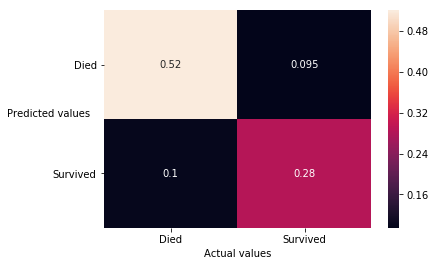

Perfomace is : 80.45% for SVM_Mean
This calculations took me : 00:00:05


In [27]:
start_time = time.time()
clf.fit(X_train_mean, y_train_mean)
y_pred_mean = clf.predict(X_test_mean)

drawConfusionMatrix(y_test_mean, y_pred_mean)

score = (((y_pred_mean == y_test_mean).sum())/y_test_mean.shape[0])
score = round(score*100,2)
SCORES["Mean"]["SVM"] = score
print("Perfomace is : {}% for SVM_Mean".format(score))
elapsed_time = time.time() - start_time
print("This calculations took me : {}".format(time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))

* If we use the df_train_median

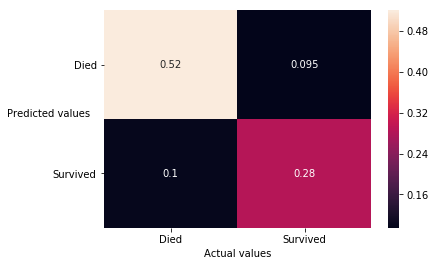

Perfomace is : 80.45% for SVM_Median
This calculations took me : 00:00:03


In [28]:
start_time = time.time()
clf.fit(X_train_median, y_train_median)
y_pred_median = clf.predict(X_test_median)

drawConfusionMatrix(y_test_median, y_pred_median)

score = (((y_pred_median == y_test_median).sum())/y_test_median.shape[0])
score = round(score*100,2)
SCORES["Median"]["SVM"] = score
print("Perfomace is : {}% for SVM_Median".format(score))
elapsed_time = time.time() - start_time
print("This calculations took me : {}".format(time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))

In [29]:
SCORES

{'Remove': {'SVM': 81.01},
 'Mean': {'SVM': 80.45},
 'Median': {'SVM': 80.45},
 'Remove_minmax': {},
 'Mean_minmax': {},
 'Median_minmax': {}}

## GridSearch to optimized Hyperparameters [see documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
The results with basic parameters for SVM are not bad, but we can find better hyperparameters with GridSearch.

In [30]:
# Dict to save best parameters
BEST_PARAMS = {"Remove":{},"Mean":{},"Median":{},"Remove_minmax":{},"Mean_minmax":{},"Median_minmax":{}}

# defining parameter range 
param_grid = [{"C": [0.1, 1, 10, 100, 1000],  
              "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
              "kernel": ["rbf", "sigmoid"]},
              {"C": [0.1, 1, 10, 100, 1000],
              "kernel": ["linear"]},
             {"C": [0.1, 1, 10, 100, 1000],  
              "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
              "kernel": ["poly"],
              "degree" : [1,2,3,4,5,6,7,8,9,10]}]
# tol and max_iter because It's taking too long to train
grid = GridSearchCV(svm.SVC(max_iter=1000000), param_grid, refit = True, verbose=3, n_jobs=-1, cv=5)
grid.fit(X_train_remove, y_train_remove) 
print("The best parameters are : {} with removed features and the score is {}".format(grid.best_params_, grid.best_score_))
score = round((grid.best_score_*100),2)
SCORES["Remove"]["SVM_BestParam"] = score
BEST_PARAMS["Remove"]["SVM"] = grid.best_params_

Fitting 5 folds for each of 305 candidates, totalling 1525 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 1041 tasks      | elapsed:   55.0s
[Parallel(n_jobs=-1)]: Done 1517 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1518 out of 1525 | elapsed:  2.1min remaining:    0.5s


The best parameters are : {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'} with removed features and the score is 0.8314606741573034


[Parallel(n_jobs=-1)]: Done 1525 out of 1525 | elapsed:  2.1min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [31]:
# defining parameter range 
param_grid = [{"C": [0.1, 1, 10, 100, 1000],  
              "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
              "kernel": ["rbf", "sigmoid"]},
              {"C": [0.1, 1, 10, 100, 1000],
              "kernel": ["linear"]},
             {"C": [0.1, 1, 10, 100, 1000],  
              "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
              "kernel": ["poly"],
              "degree" : [1,2,3,4,5,6,7,8,9,10]}]
# tol and max_iter because It's taking too long to train
grid = GridSearchCV(svm.SVC(max_iter=1000000), param_grid, refit = True, verbose=3, n_jobs=-1, cv=5)
grid.fit(X_train_mean, y_train_mean)
print("The best parameters are : {} with mean features and the score is {}".format(grid.best_params_, grid.best_score_))
score = round((grid.best_score_*100),2)
SCORES["Mean"]["SVM_BestParam"] = score
BEST_PARAMS["Mean"]["SVM"] = grid.best_params_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 305 candidates, totalling 1525 fits


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 475 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 643 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 875 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1163 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1515 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 1525 out of 1525 | elapsed:  9.1min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best parameters are : {'C': 100, 'degree': 1, 'gamma': 0.01, 'kernel': 'poly'} with mean features and the score is 0.8300561797752809


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [32]:
# defining parameter range 
param_grid = [{"C": [0.1, 1, 10, 100, 1000],  
              "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
              "kernel": ["rbf", "sigmoid"]},
              {"C": [0.1, 1, 10, 100, 1000],
              "kernel": ["linear"]},
             {"C": [0.1, 1, 10, 100, 1000],  
              "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
              "kernel": ["poly"],
              "degree" : [1,2,3,4,5,6,7,8,9,10]}]
# tol and max_iter because It's taking too long to train
grid = GridSearchCV(svm.SVC(max_iter=1000000), param_grid, refit = True, verbose=3, n_jobs=-1, cv=5)
grid.fit(X_train_median, y_train_median)
print("The best parameters are : {} with median featuresand the score is {}".format(grid.best_params_, grid.best_score_))
score = round((grid.best_score_*100),2)
SCORES["Median"]["SVM_BestParam"] = score
BEST_PARAMS["Median"]["SVM"] = grid.best_params_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 305 candidates, totalling 1525 fits


[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 928 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1216 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1525 out of 1525 | elapsed:  8.4min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best parameters are : {'C': 10, 'degree': 1, 'gamma': 0.1, 'kernel': 'poly'} with median featuresand the score is 0.8286516853932584


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [33]:
SCORES

{'Remove': {'SVM': 81.01, 'SVM_BestParam': 83.15},
 'Mean': {'SVM': 80.45, 'SVM_BestParam': 83.01},
 'Median': {'SVM': 80.45, 'SVM_BestParam': 82.87},
 'Remove_minmax': {},
 'Mean_minmax': {},
 'Median_minmax': {}}

In [34]:
BEST_PARAMS

{'Remove': {'SVM': {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}},
 'Mean': {'SVM': {'C': 100, 'degree': 1, 'gamma': 0.01, 'kernel': 'poly'}},
 'Median': {'SVM': {'C': 10, 'degree': 1, 'gamma': 0.1, 'kernel': 'poly'}},
 'Remove_minmax': {},
 'Mean_minmax': {},
 'Median_minmax': {}}

As we can see with the best scores we almost gain 2% with optimized hyperparameters.

If we plot them :

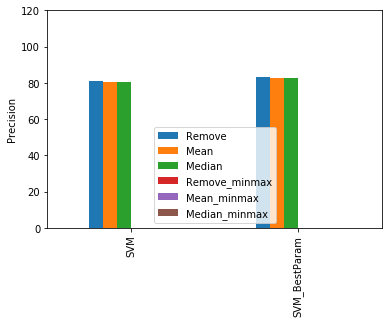

In [35]:
pd.DataFrame(SCORES).plot(kind='bar')
plt.ylim(0, 120)
plt.ylabel('Precision')
plt.show()

## With Standardized values

In [36]:
# defining parameter range 
param_grid = [{"C": [0.1, 1, 10, 100, 1000],  
              "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
              "kernel": ["rbf", "sigmoid"]},
              {"C": [0.1, 1, 10, 100, 1000],
              "kernel": ["linear"]},
             {"C": [0.1, 1, 10, 100, 1000],  
              "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
              "kernel": ["poly"],
              "degree" : [1,2,3,4,5,6,7,8,9,10]}]
# tol and max_iter because It's taking too long to train
grid = GridSearchCV(svm.SVC(max_iter=1000000), param_grid, refit = True, verbose=3, n_jobs=-1, cv=5)
grid.fit(X_train_remove_minmax, y_train_remove_minmax) 
print("The best parameters are : {} with removed features and MinMaxScaler also the score is {}".format(grid.best_params_, grid.best_score_))
score = round((grid.best_score_*100),2)
SCORES["Remove_minmax"]["SVM_BestParam"] = score
BEST_PARAMS["Remove_minmax"]["SVM"] = grid.best_params_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 305 candidates, totalling 1525 fits


[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1392 tasks      | elapsed:   18.2s


The best parameters are : {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'} with removed features and MinMaxScaler also the score is 0.8258426966292135


[Parallel(n_jobs=-1)]: Done 1525 out of 1525 | elapsed:   19.6s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [37]:
# defining parameter range 
param_grid = [{"C": [0.1, 1, 10, 100, 1000],  
              "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
              "kernel": ["rbf", "sigmoid"]},
              {"C": [0.1, 1, 10, 100, 1000],
              "kernel": ["linear"]},
             {"C": [0.1, 1, 10, 100, 1000],  
              "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
              "kernel": ["poly"],
              "degree" : [1,2,3,4,5,6,7,8,9,10]}]
# tol and max_iter because It's taking too long to train
grid = GridSearchCV(svm.SVC(max_iter=1000000), param_grid, refit = True, verbose=3, n_jobs=-1, cv=5)
grid.fit(X_train_mean_minmax, y_train_mean_minmax)
print("The best parameters are : {} with mean features and the score is {}".format(grid.best_params_, grid.best_score_))
score = round((grid.best_score_*100),2)
SCORES["Mean_minmax"]["SVM_BestParam"] = score
BEST_PARAMS["Mean_minmax"]["SVM"] = grid.best_params_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 305 candidates, totalling 1525 fits


[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 854 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 1420 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1518 out of 1525 | elapsed:  1.1min remaining:    0.2s


The best parameters are : {'C': 1, 'degree': 3, 'gamma': 1, 'kernel': 'poly'} with mean features and the score is 0.8342696629213483


[Parallel(n_jobs=-1)]: Done 1525 out of 1525 | elapsed:  1.2min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [38]:
# defining parameter range 
param_grid = [{"C": [0.1, 1, 10, 100, 1000],  
              "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
              "kernel": ["rbf", "sigmoid"]},
              {"C": [0.1, 1, 10, 100, 1000],
              "kernel": ["linear"]},
             {"C": [0.1, 1, 10, 100, 1000],  
              "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
              "kernel": ["poly"],
              "degree" : [1,2,3,4,5,6,7,8,9,10]}]
# tol and max_iter because It's taking too long to train
grid = GridSearchCV(svm.SVC(max_iter=1000000), param_grid, refit = True, verbose=3, n_jobs=-1, cv=5)
grid.fit(X_train_median_minmax, y_train_median_minmax)
print("The best parameters are : {} with median featuresand the score is {}".format(grid.best_params_, grid.best_score_))
score = round((grid.best_score_*100),2)
SCORES["Median_minmax"]["SVM_BestParam"] = score
BEST_PARAMS["Median_minmax"]["SVM"] = grid.best_params_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 305 candidates, totalling 1525 fits


[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 794 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 1355 tasks      | elapsed:   54.8s


The best parameters are : {'C': 1, 'degree': 3, 'gamma': 1, 'kernel': 'poly'} with median featuresand the score is 0.8342696629213483


[Parallel(n_jobs=-1)]: Done 1525 out of 1525 | elapsed:  1.1min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## With the KNeighborsClassifier [see documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [39]:
knn = KNeighborsClassifier(n_neighbors=3)
print("Train/Test/Record for df_train_remove")
knn.fit(X_train_remove, y_train_remove)
y_pred_remove = knn.predict(X_test_remove)
print(confusion_matrix(y_test_remove, y_pred_remove))
score = (((y_pred_remove == y_test_remove).sum())/y_test_remove.shape[0])
score = round(score*100,2)
SCORES["Remove"]["KNN_3"] = score
print("Performace is : {}% for KNN_3_Remove".format(score))
print("Train/Test/Record for df_train_mean")
knn.fit(X_train_mean, y_train_mean)
y_pred_mean = knn.predict(X_test_mean)
print(confusion_matrix(y_test_mean, y_pred_mean))
score = (((y_pred_mean == y_test_mean).sum())/y_test_mean.shape[0])
score = round(score*100,2)
SCORES["Mean"]["KNN_3"] = score
print("Performace is : {}% for KNN_3_Mean".format(score))
print("Train/Test/Record for df_train_median")
knn.fit(X_train_median, y_train_median)
y_pred_median = knn.predict(X_test_median)
print(confusion_matrix(y_test_median, y_pred_median))
score = (((y_pred_median == y_test_median).sum())/y_test_median.shape[0])
score = round(score*100,2)
SCORES["Median"]["KNN_3"] = score
print("Performace is : {}% for KNN_3_Median".format(score))

Train/Test/Record for df_train_remove
[[99 11]
 [21 48]]
Performace is : 82.12% for KNN_3_Remove
Train/Test/Record for df_train_mean
[[95 15]
 [36 33]]
Performace is : 71.51% for KNN_3_Mean
Train/Test/Record for df_train_median
[[94 16]
 [34 35]]
Performace is : 72.07% for KNN_3_Median


In [40]:
SCORES

{'Remove': {'SVM': 81.01, 'SVM_BestParam': 83.15, 'KNN_3': 82.12},
 'Mean': {'SVM': 80.45, 'SVM_BestParam': 83.01, 'KNN_3': 71.51},
 'Median': {'SVM': 80.45, 'SVM_BestParam': 82.87, 'KNN_3': 72.07},
 'Remove_minmax': {'SVM_BestParam': 82.58},
 'Mean_minmax': {'SVM_BestParam': 83.43},
 'Median_minmax': {'SVM_BestParam': 83.43}}

## Trying differents hyperparameters (again)

In [41]:
# defining parameter range 
param_grid = [{"n_neighbors": range(1,101),  
              "weights": ["uniform", "distance"],
              "algorithm": ["auto", "brute"],
              "p" : [1,2]},
             {"n_neighbors": range(1,101),  
              "weights": ["uniform", "distance"],
              "algorithm": ["ball_tree", "kd_tree"],
              "p" : [1,2],
             "leaf_size": [1,2,3,4,5,10,15,20,25,30]}]

# With Remove features
grid = GridSearchCV(KNeighborsClassifier(), param_grid, refit = True, verbose=3, n_jobs=-1, cv=5)
grid.fit(X_train_remove, y_train_remove) 
print("The best parameters are : {} with remove features and the score is {}".format(grid.best_params_, grid.best_score_))
score = round((grid.best_score_*100),2)
SCORES["Remove"]["KNN_BestParam"] = score
BEST_PARAMS["Remove"]["KNN"] = grid.best_params_

# With Mean features
grid = GridSearchCV(KNeighborsClassifier(), param_grid, refit = True, verbose=3, n_jobs=-1, cv=5)
grid.fit(X_train_mean, y_train_mean)
print("The best parameters are : {} with mean features and the score is {}".format(grid.best_params_, grid.best_score_))
score = round((grid.best_score_*100),2)
SCORES["Mean"]["KNN_BestParam"] = score
BEST_PARAMS["Mean"]["KNN"] = grid.best_params_

# With Median features
grid = GridSearchCV(KNeighborsClassifier(), param_grid, refit = True, verbose=3, n_jobs=-1, cv=5)
grid.fit(X_train_median, y_train_median)
print("The best parameters are : {} with mean features and the score is {}".format(grid.best_params_, grid.best_score_))
score = round((grid.best_score_*100),2)
SCORES["Median"]["KNN_BestParam"] = score
BEST_PARAMS["Median"]["KNN"] = grid.best_params_

# With Remove_minmax features
grid = GridSearchCV(KNeighborsClassifier(), param_grid, refit = True, verbose=3, n_jobs=-1, cv=5)
grid.fit(X_train_remove_minmax, y_train_remove_minmax) 
print("The best parameters are : {} with remove features and the score is {}".format(grid.best_params_, grid.best_score_))
score = round((grid.best_score_*100),2)
SCORES["Remove_minmax"]["KNN_BestParam"] = score
BEST_PARAMS["Remove_minmax"]["KNN"] = grid.best_params_

# With Mean_minmax features
grid = GridSearchCV(KNeighborsClassifier(), param_grid, refit = True, verbose=3, n_jobs=-1, cv=5)
grid.fit(X_train_mean_minmax, y_train_mean_minmax)
print("The best parameters are : {} with mean features and the score is {}".format(grid.best_params_, grid.best_score_))
score = round((grid.best_score_*100),2)
SCORES["Mean_minmax"]["KNN_BestParam"] = score
BEST_PARAMS["Mean_minmax"]["KNN"] = grid.best_params_

# With Median_minmax features
grid = GridSearchCV(KNeighborsClassifier(), param_grid, refit = True, verbose=3, n_jobs=-1, cv=5)
grid.fit(X_train_median_minmax, y_train_median_minmax)
print("The best parameters are : {} with mean features and the score is {}".format(grid.best_params_, grid.best_score_))
score = round((grid.best_score_*100),2)
SCORES["Median_minmax"]["KNN_BestParam"] = score
BEST_PARAMS["Median_minmax"]["KNN"] = grid.best_params_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 8800 candidates, totalling 44000 fits


[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 4296 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 7880 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12488 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 18120 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 24776 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 28696 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 33048 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 37912 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 43288 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 44000 out of 44000 | elapsed:  6.3min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will ch

The best parameters are : {'algorithm': 'ball_tree', 'leaf_size': 20, 'n_neighbors': 6, 'p': 1, 'weights': 'uniform'} with remove features and the score is 0.8300561797752809
Fitting 5 folds for each of 8800 candidates, totalling 44000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 2728 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 7848 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 11368 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 15528 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 20328 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 25768 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 31848 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 38568 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 44000 out of 44000 | elapsed:  5.7min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change f

The best parameters are : {'algorithm': 'ball_tree', 'leaf_size': 3, 'n_neighbors': 4, 'p': 1, 'weights': 'uniform'} with mean features and the score is 0.7710674157303371
Fitting 5 folds for each of 8800 candidates, totalling 44000 fits


[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 2728 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 7848 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 11368 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 15528 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 20328 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 25768 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 31848 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 38568 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 44000 out of 44000 | elapsed:  5.7min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will cha

The best parameters are : {'algorithm': 'brute', 'n_neighbors': 4, 'p': 1, 'weights': 'uniform'} with mean features and the score is 0.773876404494382
Fitting 5 folds for each of 8800 candidates, totalling 44000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 2728 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 7848 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 11368 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 15528 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 20328 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 25768 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 31848 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 38568 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 44000 out of 44000 | elapsed:  6.0min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change f

The best parameters are : {'algorithm': 'brute', 'n_neighbors': 12, 'p': 1, 'weights': 'uniform'} with remove features and the score is 0.8258426966292135
Fitting 5 folds for each of 8800 candidates, totalling 44000 fits


[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 2728 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 7848 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 11368 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 15528 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 20328 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 25638 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 28678 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 32038 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 35718 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 39718 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 44000 out of 44000 | elapsed:  7.4min finished


The best parameters are : {'algorithm': 'auto', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'} with mean features and the score is 0.8258426966292135
Fitting 5 folds for each of 8800 candidates, totalling 44000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 2984 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 4712 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 6824 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 9320 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 12200 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 15464 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 19112 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 23144 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 26306 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 28706 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 31298 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 34082 tas

The best parameters are : {'algorithm': 'auto', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'} with mean features and the score is 0.8286516853932584


[Parallel(n_jobs=-1)]: Done 44000 out of 44000 | elapsed: 12.9min finished


# Random Forest Classifier

In [42]:
RF = RandomForestClassifier(n_estimators=100)
print("Train/Test/Record for df_train_remove")
RF.fit(X_train_remove, y_train_remove)
y_pred_remove = RF.predict(X_test_remove)
print(confusion_matrix(y_test_remove, y_pred_remove))
score = (((y_pred_remove == y_test_remove).sum())/y_test_remove.shape[0])
score = round(score*100,2)
SCORES["Remove"]["RF_100"] = score
print("Performace is : {}% for RF_100_Remove".format(score))
print("Train/Test/Record for df_train_mean")
RF.fit(X_train_mean, y_train_mean)
y_pred_mean = RF.predict(X_test_mean)
print(confusion_matrix(y_test_mean, y_pred_mean))
score = (((y_pred_mean == y_test_mean).sum())/y_test_mean.shape[0])
score = round(score*100,2)
SCORES["Mean"]["RF_100"] = score
print("Performace is : {}% for RF_100_Mean".format(score))
print("Train/Test/Record for df_train_median")
RF.fit(X_train_median, y_train_median)
y_pred_median = RF.predict(X_test_median)
print(confusion_matrix(y_test_median, y_pred_median))
score = (((y_pred_median == y_test_median).sum())/y_test_median.shape[0])
score = round(score*100,2)
SCORES["Median"]["RF_100"] = score
print("Performace is : {}% for RF_100_Median".format(score))

Train/Test/Record for df_train_remove
[[98 12]
 [19 50]]
Performace is : 82.68% for RF_100_Remove
Train/Test/Record for df_train_mean
[[98 12]
 [20 49]]
Performace is : 82.12% for RF_100_Mean
Train/Test/Record for df_train_median
[[98 12]
 [19 50]]
Performace is : 82.68% for RF_100_Median


## Trying differents hyperparameters (and again)

In [43]:
# defining parameter range 
param_grid = [{"n_estimators": range(1,251),  
               "criterion": ["gini", "entropy"],
               "max_depth": [1,2,3,4,5, None]
              }]

# With Remove features
grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose=3, n_jobs=-1, cv=5)
grid.fit(X_train_remove, y_train_remove) 
print("The best parameters are : {} with remove features and the score is {}".format(grid.best_params_, grid.best_score_))
score = round((grid.best_score_*100),2)
SCORES["Remove"]["RF_BestParam"] = score
BEST_PARAMS["Remove"]["RF"] = grid.best_params_

# With Mean features
grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose=3, n_jobs=-1, cv=5)
grid.fit(X_train_mean, y_train_mean)
print("The best parameters are : {} with mean features and the score is {}".format(grid.best_params_, grid.best_score_))
score = round((grid.best_score_*100),2)
SCORES["Mean"]["RF_BestParam"] = score
BEST_PARAMS["Mean"]["RF"] = grid.best_params_

# With Median features
grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose=3, n_jobs=-1, cv=5)
grid.fit(X_train_median, y_train_median)
print("The best parameters are : {} with mean features and the score is {}".format(grid.best_params_, grid.best_score_))
score = round((grid.best_score_*100),2)
SCORES["Median"]["RF_BestParam"] = score
BEST_PARAMS["Median"]["RF"] = grid.best_params_

# With Remove_minmax features
grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose=3, n_jobs=-1, cv=5)
grid.fit(X_train_remove_minmax, y_train_remove_minmax) 
print("The best parameters are : {} with remove features and the score is {}".format(grid.best_params_, grid.best_score_))
score = round((grid.best_score_*100),2)
SCORES["Remove_minmax"]["RF_BestParam"] = score
BEST_PARAMS["Remove_minmax"]["RF"] = grid.best_params_

# With Mean_minmax features
grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose=3, n_jobs=-1, cv=5)
grid.fit(X_train_mean_minmax, y_train_mean_minmax)
print("The best parameters are : {} with mean features and the score is {}".format(grid.best_params_, grid.best_score_))
score = round((grid.best_score_*100),2)
SCORES["Mean_minmax"]["RF_BestParam"] = score
BEST_PARAMS["Mean_minmax"]["RF"] = grid.best_params_

# With Median_minmax features
grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose=3, n_jobs=-1, cv=5)
grid.fit(X_train_median_minmax, y_train_median_minmax)
print("The best parameters are : {} with mean features and the score is {}".format(grid.best_params_, grid.best_score_))
score = round((grid.best_score_*100),2)
SCORES["Median_minmax"]["RF_BestParam"] = score
BEST_PARAMS["Median_minmax"]["RF"] = grid.best_params_

Fitting 5 folds for each of 3000 candidates, totalling 15000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 689 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 1813 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2535 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3729 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 5004 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 6356 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 8078 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 9895 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 12062 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 14231 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 14993 out of 15000 | elapsed: 13.2min remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 15000 out of 15000 | elapsed: 13.2min finished
C:\Progr

The best parameters are : {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 32} with remove features and the score is 0.8314606741573034
Fitting 5 folds for each of 3000 candidates, totalling 15000 fits


[Parallel(n_jobs=-1)]: Done 392 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 812 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 1892 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2382 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3351 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4594 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 5868 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 7345 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 9898 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 13169 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 14993 out of 15000 | elapsed: 10.0min remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 15000 out of 15000 | elapsed: 10.0min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will chang

The best parameters are : {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 7} with mean features and the score is 0.8384831460674157
Fitting 5 folds for each of 3000 candidates, totalling 15000 fits


[Parallel(n_jobs=-1)]: Done 424 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 938 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 1799 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 2550 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3956 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 5588 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 7653 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 10139 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 12315 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 14747 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 14993 out of 15000 | elapsed:  6.9min remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 15000 out of 15000 | elapsed:  6.9min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0

The best parameters are : {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 22} with mean features and the score is 0.8356741573033708
Fitting 5 folds for each of 3000 candidates, totalling 15000 fits


[Parallel(n_jobs=-1)]: Done 424 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 1169 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 2310 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 3521 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 5049 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 7177 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 9657 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 12361 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 14869 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 14993 out of 15000 | elapsed:  6.5min remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 15000 out of 15000 | elapsed:  6.5min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are u

The best parameters are : {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 97} with remove features and the score is 0.8300561797752809
Fitting 5 folds for each of 3000 candidates, totalling 15000 fits


[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 992 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 1820 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 3293 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4875 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 6283 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 8655 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 10963 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 13405 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 14993 out of 15000 | elapsed:  6.9min remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 15000 out of 15000 | elapsed:  6.9min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are un

The best parameters are : {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 134} with mean features and the score is 0.8356741573033708
Fitting 5 folds for each of 3000 candidates, totalling 15000 fits


[Parallel(n_jobs=-1)]: Done 392 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1154 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 2096 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 3205 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4585 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 6391 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 8055 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 10363 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 13171 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 14993 out of 15000 | elapsed:  7.0min remaining:    0.1s


The best parameters are : {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 44} with mean features and the score is 0.8342696629213483


[Parallel(n_jobs=-1)]: Done 15000 out of 15000 | elapsed:  7.0min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


If we plot the results

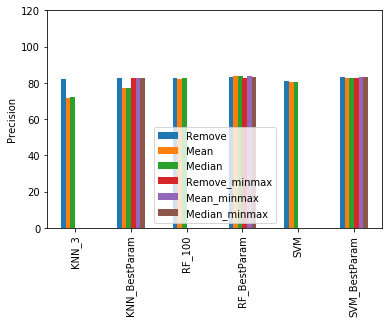

In [45]:
pd.DataFrame(SCORES).plot(kind='bar')
plt.ylim(0, 120)
plt.ylabel('Precision')
plt.show()

In [46]:
SCORES

{'Remove': {'SVM': 81.01,
  'SVM_BestParam': 83.15,
  'KNN_3': 82.12,
  'KNN_BestParam': 83.01,
  'RF_100': 82.68,
  'RF_BestParam': 83.15},
 'Mean': {'SVM': 80.45,
  'SVM_BestParam': 83.01,
  'KNN_3': 71.51,
  'KNN_BestParam': 77.11,
  'RF_100': 82.12,
  'RF_BestParam': 83.85},
 'Median': {'SVM': 80.45,
  'SVM_BestParam': 82.87,
  'KNN_3': 72.07,
  'KNN_BestParam': 77.39,
  'RF_100': 82.68,
  'RF_BestParam': 83.57},
 'Remove_minmax': {'SVM_BestParam': 82.58,
  'KNN_BestParam': 82.58,
  'RF_BestParam': 83.01},
 'Mean_minmax': {'SVM_BestParam': 83.43,
  'KNN_BestParam': 82.58,
  'RF_BestParam': 83.57},
 'Median_minmax': {'SVM_BestParam': 83.43,
  'KNN_BestParam': 82.87,
  'RF_BestParam': 83.43}}

In [47]:
BEST_PARAMS

{'Remove': {'SVM': {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'},
  'KNN': {'algorithm': 'ball_tree',
   'leaf_size': 20,
   'n_neighbors': 6,
   'p': 1,
   'weights': 'uniform'},
  'RF': {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 32}},
 'Mean': {'SVM': {'C': 100, 'degree': 1, 'gamma': 0.01, 'kernel': 'poly'},
  'KNN': {'algorithm': 'ball_tree',
   'leaf_size': 3,
   'n_neighbors': 4,
   'p': 1,
   'weights': 'uniform'},
  'RF': {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 7}},
 'Median': {'SVM': {'C': 10, 'degree': 1, 'gamma': 0.1, 'kernel': 'poly'},
  'KNN': {'algorithm': 'brute',
   'n_neighbors': 4,
   'p': 1,
   'weights': 'uniform'},
  'RF': {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 22}},
 'Remove_minmax': {'SVM': {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'},
  'KNN': {'algorithm': 'brute',
   'n_neighbors': 12,
   'p': 1,
   'weights': 'uniform'},
  'RF': {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 97}},
 'Mean_minmax': {'SVM': {'C': 1, 'degree'

<a id="conclusion"></a>
## Conclusion and trial over the test sample

From all these tests we can conclude that the best model is the SVM with best_param with 83.15% and remove features.

So if we do it with the real test data :

In [ ]:
X_train = df_train_remove.drop(["Survived"], axis=1)
Y_train = df_train_remove["Survived"]
X_test = df_test_remove

In [ ]:
BEST_PARAMS["Remove"]["SVM"]

In [ ]:
start_time = time.time()
clf = svm.SVC(C = 1, gamma = 0.1, kernel = 'rbf') #Use best params
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)

In [ ]:
# Creation of the submission file :
DF_Fin = pd.DataFrame(columns=["PassengerId","Survived"])
DF_Fin["PassengerId"] = df_test_org["PassengerId"]
DF_Fin["Survived"] = y_pred

DF_Fin.head()